## Correcting ICESat-2 data and related applications

Maya Becker and Susheel Adusumilli, Scripps Institution of Oceanography, UC San Diego

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from is2_utils import *
import geopandas as gpd
from matplotlib import path, patches
from glob import glob
import h5py
from scipy.io import loadmat

### Part 1: Application of geophysical corrections over ice shelves

In the first part of this tutorial, we will discuss which geophysical corrections we need to apply in which scenarios. As data over floating ice shelves require several corrections, we will focus on this type of surface. Many of the corrections that we apply to altimetry data over ice shelves are also required for science applications of altimetry data over icebergs and sea ice, so we hope that this tutorial can prove useful for both ice-shelf scientists and those who focus on other elements of the cryosphere.

You can find an overview of the corrections applied to the ICESat-2 ATL03 data in Markus et al. (2017). We will not discuss the solid earth tides correction, solid earth and ocean pole tide corrections, and atmospheric range delay correction.

We will start with the same ATL06 data that Ben used in his cloud and data quality tutorial (i.e., the HDF5 data over Byrd Glacier). We will use a modified version of the code that he ran to extract the fields relevant to this tutorial from each HDF5 file: latitude, longitude, land-ice height, ocean tide correction, ocean tidal loading correction, dynamic atmosphere correction (with inverted barometer effect), and geoid height. Note that this code also includes a conversion of the latitude–longitude pairs to polar stereographic x-y grid coordinates, done with a function stored in is2_utils.py.

Download the relevant data for the tutorial here
s3://pangeo-data-upload-oregon/icesat2/data-correction/

In [6]:
external_data = '/home/jovyan/external_data'
data_dir = external_data + '/Byrd_glacier'
D6 = []
datasets = {'land_ice_segments': ['h_li','latitude','longitude','atl06_quality_summary'],
             'land_ice_segments/geophysical': ['tide_load','dac','tide_ocean'],
             'land_ice_segments/dem': ['geoid_h']}
files = glob(data_dir + '/*.h5')

pairs=[1, 2, 3]
beams=['r']
for file in files[::2]:
    this_name = os.path.basename(file)
    with h5py.File(file) as h5f:
        for pair in pairs:
            for beam in beams:
                temp = {}
                for group in datasets.keys():
                    for dataset in datasets[group]:
                        DS = '/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        try:
                            temp[dataset] = np.array(h5f[DS])                            
                            if '_FillValue' in h5f[DS].attrs: # Converting Fortran NaNs to Python NaNs
                                fill_value = h5f[DS].attrs['_FillValue']
                                temp[dataset][temp[dataset] == fill_value] = np.NaN
                        except KeyError:
                            pass
                if len(temp) > 0:
                    temp['x'],temp['y'] = ll2ps(temp['longitude'],temp['latitude'], \
                                                    slat=71, slon=0, hemi='s', units='m')
                    temp['mask'] = np.empty_like(temp['y'])
                    temp['h_li'][temp['atl06_quality_summary']] = np.NaN
                    D6.append(temp)
                    
print("read %d beams" % (len(D6)))

read 266 beams


Now let's see what the data look like.

(-1200000, -800000)

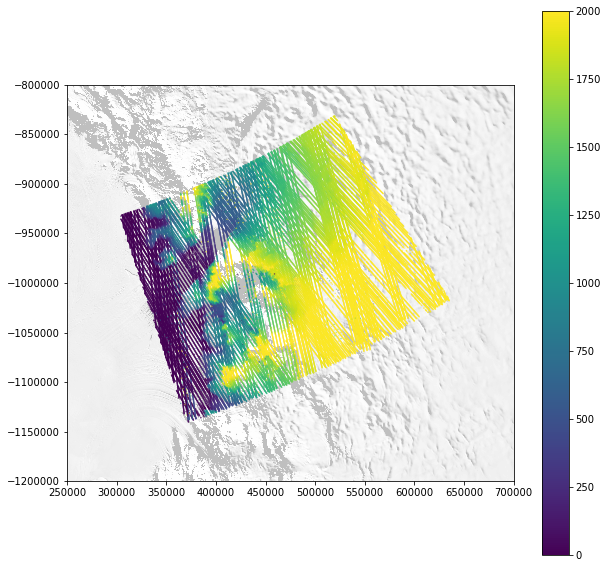

In [7]:
plt.figure(figsize = (10,10))

def plot_moa():
    moa = loadmat(external_data + '/byrd_moa.mat')
    extent = [np.min(moa['x']),np.max(moa['x']),np.min(moa['y']),np.max(moa['y'])]
    plt.imshow(np.squeeze(moa['moa']),extent=extent)

plot_moa()
for Di in D6:
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['h_li'][::20],s = 0.1,vmin = 0,vmax = 2000)
plt.colorbar()

plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])

#### Masking the grounded ice

First things first, we need to mask out the grounded ice so that we only apply the floating-ice corrections to the ATL06 data for the area of Ross Ice Shelf fed by Byrd.

We use ice-shelf polygons (available at https://nsidc.org/data/nsidc-0709) to subset the data over floating ice. The floating-/grounded-ice mask used by NASA to apply the tide models to ICESat-2 data is at quite a low resolution, so it is preferable to mask the data seperately. First, we load the shapefile 'IceShelf_Antarctica_v1.shp' and plot all the ice shelf polygons. (Note that you also need to have the corresponding CPG, DBF, PRJ, and SHX files accessible in order for the shapefile to be loaded successfully.)

Text(0.5, 1.0, 'Antarctic ice-shelf polygons')

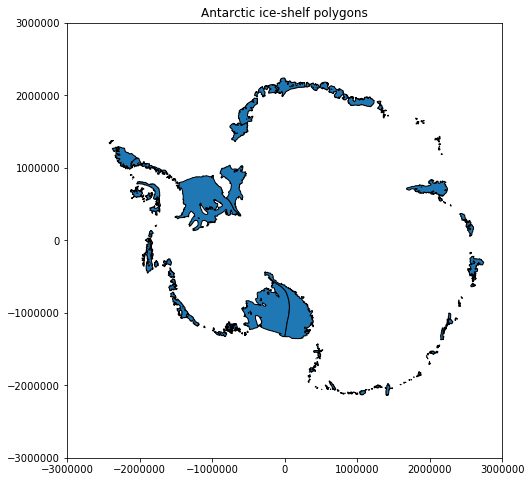

In [8]:
from descartes.patch import PolygonPatch

plt.figure(figsize = (8,8))
ax = plt.axes()
ax.set_aspect('equal')

shapefile = gpd.read_file(external_data + '/IceShelf_Antarctica_v1.shp')
for polygon in shapefile.geometry:
    patch = PolygonPatch(polygon)
    ax.add_patch(patch)
plt.xlim([-3000e3,3000e3])
plt.ylim([-3000e3,3000e3])
plt.title('Antarctic ice-shelf polygons')


Because we are only interested in Byrd Glacier, we use the polygon for the East Antarctic Ice Sheet (EAIS) section of Ross Ice Shelf to identify the area of floating ice. We also append the coordinate pairs corresponding to the floating area to the list 'D6.' Plotting all of the points takes quite a while, so we only plot every 20th point for the sake of time.

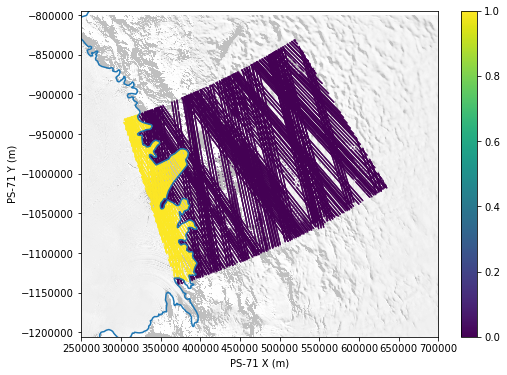

In [10]:
polygon = shapefile.geometry[76] # Item 76 is the polygon for the EAIS section of Ross Ice Shelf
xp, yp = polygon.exterior.coords.xy
coords = np.squeeze(np.dstack((xp,yp)))
poly_mpl = path.Path(coords)

for Di in D6: # Add 'mask' dataset (containing the x-y coordinate pairs within the mask) to list D6 for each beam/pair combination
    Di['mask'] = poly_mpl.contains_points(np.transpose([Di['x'],Di['y']]))

plt.figure(figsize = (8,6))

plot_moa()
plt.plot(*polygon.exterior.xy);

for Di in D6:
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['mask'][::20],s = 0.1)
    plt.clim([0,1])
plt.axis('equal')
plt.xlabel('PS-71 X (m)')
plt.ylabel('PS-71 Y (m)')
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.colorbar()

#### Ocean tides and ocean tidal loading

TO ADD: discussion of different tide models for different regions, image of CATS2008 tide model outputs for this region

Let us first take a quick look at the spatial variability of the GOT 4.8 model output for the ocean tides and ocean tidal loading in the floating section of the Byrd Glacier data. This should take a moment to run.

In [ ]:
plt.figure(figsize = (16,6))

plt.subplot(121)
for Di in D6:
    plt.scatter(Di['x'][::10],Di['y'][::10],c = Di['tide_ocean'][::10],s = 0.1,vmin=-1,vmax=1)
plt.colorbar()
plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.axis('equal')

plt.subplot(122)
for Di in D6:
    plt.scatter(Di['x'][::10],Di['y'][::10],c = Di['tide_load'][::10],s = 0.1,vmin=-0.01,vmax=0.01)
plt.colorbar()
plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])    
plt.axis('equal')

Note the difference in scale between both corrections! The ATL06 data are already corrected for ocean tidal loading, so we only need to account for the ocean tides before we move on to the dynamic atmosphere correction.

#### Dynamic atmosphere correction and inverted barometer effect

TO ADD: overview of DAC and Mog2D product
DAC/IBE are not applicable over land, however, so we need to mask them out.

In [ ]:
plt.figure(figsize = (8,6))
for Di in D6:
    plt.scatter(Di['x'][Di['mask']][::10],Di['y'][Di['mask']][::10],c = Di['dac'][Di['mask']][::10],s = 0.1,vmin=0,vmax=0.5)
plt.colorbar()
plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.axis('equal')

#### Mean dynamic topography

(Include overview of MDT correction and Mog2D product)

#### Conversion to geoid model

(Include overview of referencing heights to a geoid and different geoid models available)

### Part 2: Derivation of ice-shelf height changes and conversion to mass changes

In [ ]:
from netCDF4 import Dataset

#### Correction for the presence of a firn layer

TO ADD: Discussion of different firn products, typical plot of firn column density

We will now use a quantity called firn air content (FAC; see Ligtenberg et al. [2011]) from RACMO to correct for the presence of a firn layer of a certain mass and volume. In essence, FAC describes the "length" of the firn air column, which is estimated as the thickness change that would result from the compression of the firn column to the density of ice.

In [ ]:
FAC = Dataset(external_data + '/FDM_FirnAir_ANT27_1979-2016.nc')

print(FAC.file_format)
print(FAC.dimensions.keys()) # in this case, dimensions represent the physical dimensions assigned to each variable
print(FAC.variables.keys()) # variables are arrays of values where the bulk of the information is stored

In [ ]:
lat_fac = FAC.variables['lat'][:]
lon_fac = FAC.variables['lon'][:]
FirnAir = FAC.variables['FirnAir'][:]
time_fac = FAC.variables['time'][:]
print("minimum longitude: %g degrees" % (np.min(lons)))
print("maximum longitude: %g degrees" % (np.max(lons)))

Let us take a quick look at how FAC varied across the Ross Ice Shelf region in the year 2016.

In [ ]:
time_16_inds = np.where((time_fac > 2015.99) & (time_fac < 2017))
time_16 = time[time_16_inds]
FirnAir_16 = FirnAir[time_16_inds,:,:]
meanFirnAir_16 = np.squeeze(np.mean(FirnAir_16,1))

plt.figure(figsize = (18,8))
[x,y] = ll2ps(lon_fac,lat_fac,slat=71, slon=0, hemi='s', units='m')
ax = plt.subplot(121)
plt.contourf(x,y,meanFirnAir_16)
plt.axis('equal')
plt.colorbar()
for polygon in shapefile.geometry:
    plt.plot(*polygon.exterior.xy,color='black');
p = patches.Rectangle((250000, -1300000),450000,500000,fill=False,color='white')
ax.add_patch(p)

plt.subplot(122)
plt.contourf(x,y,meanFirnAir_16)
plt.axis('equal')
plt.colorbar()
for polygon in shapefile.geometry:
    plt.plot(*polygon.exterior.xy,color='black');
plt.xlim([250000,700000])
plt.ylim([-1300000,-800000])
    

#### Conversion from height above mean sea surface (h_MSS) to thickness with RACMO h_FAC

#### Conversion from height changes to mass changes with RACMO h_total (= h_FAC + h_SMB)

In [ ]:
from datetime import date, timedelta
SMB_data = Dataset(external_data + '/SMB_RACMO2.4_monthly_ANT27_197901_201612.nc')
lat_smb = SMB_data.variables['lat'][:]
lon_smb = SMB_data.variables['lon'][:]
SMB = SMB_data.variables['smb'][:]
time_smb = timedelta(SMB_data.variables['time'][:])
time_smb = date(1950,1,1) + time_smb

In [ ]:
inds = np.where((lon_fac > 148) & (lon_fac < 162) & (lat_fac > -81) & (lat_fac < -79))
mean_fac = np.empty_like(time_fac)
for i in range(0,len(time_fac)):
    mean_fac_ = np.squeeze(FirnAir[i,:,:])
    mean_fac[i] = np.mean(mean_fac_[inds])
    
inds = np.where((lon_smb > 148) & (lon_smb < 162) & (lat_smb > -81) & (lat_smb < -79))
mean_smb = np.empty_like(time_smb)
for i in range(0,len(time_smb)):
    mean_smb_ = np.squeeze(SMB[i,:,:])
    mean_smb[i] = np.mean(mean_smb_[inds])

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(time_smb,mean_smb)

In [ ]:
extent